# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Jacopo De Stefani - __[Jacopo.De.Stefani@ulb.ac.be](mailto:Jacopo.De.Stefani@ulb.ac.be)__
### Bertrand Lebichot - __[Bertrand.Lebichot@ulb.ac.be](mailto:Bertrand.Lebichot@ulb.ac.be)__
### Arnaud Pollaris - __[Arnaud.Pollaris@ulb.ac.be](mailto:Arnaud.Pollaris@ulb.ac.be)__
### Gianluca Bontempi - __[gbonte@ulb.ac.be](mailto:gbonte@ulb.ac.be)__

## TP 5 - Predictions: Network-based methods

####  April 23,2019 

## Goal and dataset

The goal is to review some ML concepts :

* Neural Network
* Cross-validation and bagging
* Radial Basis Functions

We will continue to work on the spam detection dataset (https://archive.ics.uci.edu/ml/datasets/spambase), using the package ``nutshell``.

In [1]:
library(nutshell)
library(nnet)
library(devtools)
library(RSNNS)
data(spambase)
source_url('https://gist.githubusercontent.com/Peque/41a9e20d6687f2f3108d/raw/85e14f3a292e126f1454864427e3a189c2fe33f3/nnet_plot_update.r')


Warning message:
"package 'nutshell' was built under R version 3.4.4"Loading required package: nutshell.bbdb
Warning message:
"package 'nutshell.bbdb' was built under R version 3.4.4"Loading required package: nutshell.audioscrobbler
Warning message:
"package 'nutshell.audioscrobbler' was built under R version 3.4.4"Warning message:
"package 'devtools' was built under R version 3.4.2"Warning message:
"package 'RSNNS' was built under R version 3.4.4"Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.4.4"SHA-1 hash of file is bf3c7b8ac910823b729e3ce73bb6ab5e6955ad3d


In [2]:
accuracyFromConfusionMatrix <- function(confusion_matrix){
    return((confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix))
}

displayResults <- function(Y,Y_hat,explanatory_string=""){
    print(paste("[INFO] - Confusion matrix",explanatory_string,":"))
    confusion_matrix <- table(Y_hat,(Y == 1))
    print(confusion_matrix)
    accuracy <- accuracyFromConfusionMatrix(confusion_matrix)
    misclassification_rate = 1 - accuracy
    print(paste("[INFO] - Misclassification rate",explanatory_string,":",misclassification_rate))
    return(accuracy)
}



## Classification with Neural Networks

In machine learning and cognitive science, an artificial neural network (ANN) is a network 
of interconnected processing elements, called neurons, which are used to estimate or approximate functions that can depend on a large number of inputs that are generally unknown.
The concept of artificial neural networks is inspired by the structure of the central nervous systems of animals, in particular the brain. 
In such biological neural networks, a set of units (i.e. the neurons) are interconnected with each other to form a data-processing network. The processing capability of the network depends on the strength of the connections between the neurons, which can be dynamically modified across time in response to external stimuli that the network is subject to.
This dynamic adaptation of the connections gives this system the possibility to learn from the experiences it is subject to.

Both artificial and neural networks are characterized by three features \parencite{mackay2003information} : **architecture**, **activity** and **learning rules**:

- The **architecture** is a specification of which input variables are involved in the network and what are the topological relationships between the nodes of the network.
- The **activity rule** describes defines how the activities of the neurons change in response to each other (usually with a short time-scale dynamics).
- The **learning rule** specifies the way in which the neural network's weights needs to be adapted with time. This learning is usually viewed as taking place on a longer time scale than the time scale of the dynamics under the activity rule. Usually the learning rule will depend on the activities of the neurons. It may also depend on the values of the target values supplied by a teacher.


For our task, we will focus on a specific family of artificial neural networks, the multi-layer perceptron (MLP). 
The **architecture** of a multi-layer perceptron is organized in layers, with each layer being fully connected to the following. The first layer, also called input layer, is constituted by the input variables. Following it there are one or more intermediate layers, named hidden layers, yielding to an output layer with one output variable. In this type of network, information moves from the input nodes, through the hidden nodes, to the output node. Moreover, every connection between nodes has an associated weight.

In the following, we will focus on a standard one-hidden layer network:
![](ANN_FF.png)

Described by the equation :
\begin{equation}
m(\mathbf{x}) = f_o \left( b_o + \sum_{j=1}^{|H|} w_{jo} \cdot f_h \left( \sum_{k=1}^{|I|} w_{ik} x_{ik} + b_j  \right) \right)
\end{equation}


where $\mathbf{x'}$ is the input vector $\mathbf{x}$, augmented with 1, i.e., $\mathbf{x'}= (1;\mathbf{x}^T)^T$ , 
$w_{ij}$ is the weight of the connection between the $i^\text{th}$ input node and the $j^\text{th}$ hidden node, $w_{jo}$ are the weights of the connections between hidden node $j$ and the output node and $|H|$ is the number of hidden nodes. The number of hidden nodes ($|H|$) controls the complexity of the model. 


The **activation rule** of such network is divided into two steps.
Firstly, each node $j$ determines its activation $a_j$, by collecting the output of its input nodes:
\begin{equation}
a_j = \sum_{i} w_{ij} x_i 
\end{equation}
Then, the *activity* of the neuron is computed as a function of the value of the activation $a_j$. In the case of the considered network, we have two different activity functions: $f_h(\cdot)$ for the hidden layer and $f_o(\cdot)$ for the output node.
Common choices for activity functions are:

\begin{align*}
f(x) = x && \text{Linear} \\
f(x) = \frac{1}{1+e^{-x}} && \text{Logistic} \\
f(x) = \tanh(x) && \text{Hyperbolic tangent} \\
f(x) = 
\begin{cases}
1 & x > 0 \\
-1 & x \le 0 \\
\end{cases} && \text{Threshold} \\
\end{align*}


Concerning the **learning rule**, the weights are generally estimated using some specific
optimization procedure, the most popular one being the backpropagation procedure \parencite{rumelhart1988learning}. Usually, at the beginning, the weights are chosen to be random values near zero and the backpropagation procedure updates the weights in order to minimize the prediction errors. The backpropagation procedure could be done using all the available data in a single session (batch training) or providing the network one training example at a time (online training).
The error function minimized by neural networks is nonconvex and so can have multiple local
minima. In consequence, the final solution will depend on the value chosen as starting point.
Because of this randomness, neural networks are often trained multiple times using different
random starting values, and the outputs of the different networks are averaged to obtain the final predictions.


## Data analysis

In [46]:
spambase_idx <- sample(1:nrow(spambase))
half_split <- floor(nrow(spambase)/2)
target_variable <- ncol(spambase)

train_data <- spambase[spambase_idx[1:half_split],]
test_data <- spambase[spambase_idx[(half_split+1):nrow(spambase)],]
threshold <- 0.5


In [47]:
pca <- prcomp(spambase[, -target_variable],center=TRUE,scale.=TRUE,retx=TRUE)

train_data_pca <- pca$x[spambase_idx[1:half_split],]
test_data_pca <- pca$x[spambase_idx[(half_split+1):nrow(spambase)],]

In [54]:
dim(train_data_pca[,1:5])

[1] 2300    5

Before starting with the implementation of the models, we will have a deeper look into the data. To be more precise, we will focus on the target variable ``ìs_spam``.

In [93]:
class(train_data[,target_variable])

[1] "factor"

As the target variable is a categorical variable (i.e. a variable taking values from a fixed and limited set of values), neural networks cannot naturally deal with values that are not numeric.

We than have two different possibilities to solve this issue:

- **integer encoding** : Each category will be coded with an increasing integer number (e.g. 1,2,3,....)
    - **Pro's** : Efficient encoding (especially with a large number of variables)
    - **Con's** : Natural relation among coded values
- **one-hot encoding** : Each category will be coded with an vector having a number of entries equal to the available categories
    - **Pro's** : No relation among coded values
    - **Con's** : Potentially high number of dummy output variables need to be added to the model

In [97]:
print("Integer encoding of is_spam:")
head(train_data[,target_variable])
print("One-hot encoding of is_spam:")
head(class.ind(as.factor(train_data[,target_variable])))

[1] "Integer encoding of is_spam:"


[1] 1 1 0 0 0 1
Levels: 0 1

[1] "One-hot encoding of is_spam:"


0,1
0,1
0,1
1,0
1,0
1,0
0,1


### MLP - Single output network

We will start by applying a multi layer perceptron to our problem.
The input layer will be constituted by 57 neurons, one for each input variable in the Spambase dataset.
The output layer will contain a single neuron, outputting the probability for the given input example, to be classified as spam.
The hidden layer will be constituted by a given number (``hidden_neurons <- 5``) of hidden units.
The objective of the **learning rule** here, is to tune the weights of the network in order to minimize the mean squared difference between the output of the network $\hat{y}$ and the true values $y$.

In [75]:
hidden_nodes <- 5

model_single_out <- nnet(is_spam ~ ., data=train_data,size=hidden_nodes,skip=FALSE,trace=T, maxit=3000,rang=0.2)
model_single_out

Y_pred<-predict(model_single_out,test_data[,-target_variable])
Y_hat_single_out <- Y_pred > threshold 

head(Y_pred)

# weights:  296
initial  value 1558.958360 
iter  10 value 1357.424927
iter  20 value 905.208838
iter  30 value 722.924656
iter  40 value 628.665519
iter  50 value 443.148847
iter  60 value 363.486830
iter  70 value 306.564699
iter  80 value 278.575777
iter  90 value 244.017198
iter 100 value 224.866944
iter 110 value 202.516909
iter 120 value 186.690561
iter 130 value 178.093456
iter 140 value 174.536682
iter 150 value 172.726899
iter 160 value 171.866747
iter 170 value 170.608248
iter 180 value 170.478232
iter 190 value 170.474276
iter 200 value 170.473952
iter 200 value 170.473950
final  value 170.473919 
converged


a 57-5-1 network with 296 weights
inputs: word_freq_make word_freq_address word_freq_all word_freq_3d word_freq_our word_freq_over word_freq_remove word_freq_internet word_freq_order word_freq_mail word_freq_receive word_freq_will word_freq_people word_freq_report word_freq_addresses word_freq_free word_freq_business word_freq_email word_freq_you word_freq_credit word_freq_your word_freq_font word_freq_000 word_freq_money word_freq_hp word_freq_hpl word_freq_george word_freq_650 word_freq_lab word_freq_labs word_freq_telnet word_freq_857 word_freq_data word_freq_415 word_freq_85 word_freq_technology word_freq_1999 word_freq_parts word_freq_pm word_freq_direct word_freq_cs word_freq_meeting word_freq_original word_freq_project word_freq_re word_freq_edu word_freq_table word_freq_conference char_freq_semicolon char_freq_left_paren char_freq_left_bracket char_freq_exclamation char_freq_dollar char_freq_pound capital_run_length_average capital_run_length_longest capital_run_length_total 
o

3807,2.016867e-05
621,9.908771e-01
1881,4.387432e-03
1343,9.908771e-01
3458,9.908771e-01
3701,5.642029e-03


We will then use a custom function (cf. https://beckmw.wordpress.com/2013/03/04/visualizing-neural-networks-from-the-nnet-package/) to visualize the fitted network

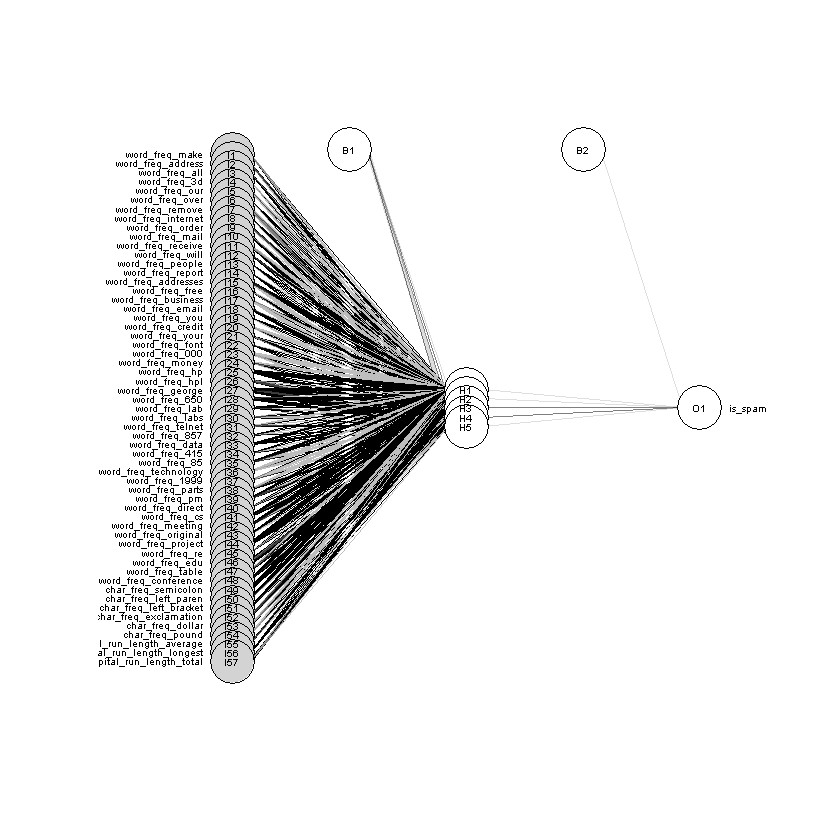

In [46]:
plot.nnet(model_single_out, alpha.val = 0.5, circle.col = list('lightgray', 'white'), bord.col = 'black', cex=0.5)

### MLP - One hot encoding network

In [90]:
model_one_hot<-nnet(x=train_data[,-target_variable],
               y=class.ind(as.factor(train_data[,target_variable])),
               size=hidden_nodes,
               skip=FALSE,
               trace=T, 
               maxit=1000,
               rang=0.5)

model_one_hot

Y_pred<-predict(model_one_hot,test_data[,-target_variable])
Y_hat_one_hot <- Y_pred[,2] > threshold

head(Y_pred)

# weights:  302
initial  value 1347.184241 
iter  10 value 1012.498998
iter  20 value 817.514392
iter  30 value 460.009833
iter  40 value 308.116019
iter  50 value 238.722154
iter  60 value 201.134558
iter  70 value 184.313271
iter  80 value 166.249169
iter  90 value 160.722169
iter 100 value 156.614153
iter 110 value 154.129084
iter 120 value 153.258905
iter 130 value 153.027568
iter 140 value 152.643174
iter 150 value 152.463671
iter 160 value 152.301060
iter 170 value 152.143596
iter 180 value 151.961107
iter 190 value 151.841063
iter 200 value 151.698976
iter 210 value 151.487322
iter 220 value 151.316655
iter 230 value 151.165369
iter 240 value 150.680352
iter 250 value 149.935599
iter 260 value 149.207127
iter 270 value 149.090961
iter 280 value 148.998750
iter 290 value 148.943049
iter 300 value 148.868398
iter 310 value 148.739892
iter 320 value 148.680460
iter 330 value 148.647584
iter 340 value 148.590201
iter 350 value 148.543949
iter 360 value 148.496356
iter 370 value 148.

a 57-5-2 network with 302 weights
options were -

,0,1
3807,1.0000000,0.000000000
621,0.0000000,1.000000000
1881,1.0000000,0.000000000
1343,0.0000000,1.000000000
3458,0.9969206,0.003081287
3701,0.8071650,0.192843254


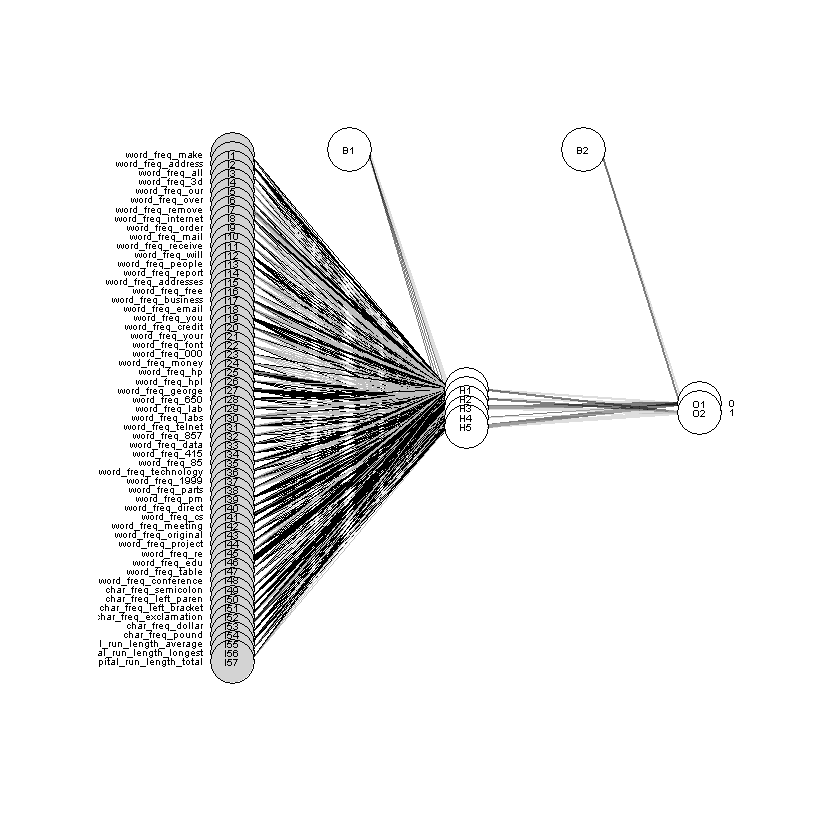

In [47]:
plot.nnet(model_one_hot, alpha.val = 0.5, circle.col = list('lightgray', 'white'), bord.col = 'black', cex=0.5)

In [112]:
Y <- test_data[,target_variable]

displayResults(Y,Y_hat_single_out,"Single out")
displayResults(Y,Y_hat_one_hot,"One hot")


[1] "[INFO] - Confusion matrix Single out :"
       
Y_hat   FALSE TRUE
  FALSE  1280   65
  TRUE     95  861
[1] "[INFO] - Misclassification rate Single out : 0.069534984789222 \n"
[1] "[INFO] - Confusion matrix One hot :"
       
Y_hat   FALSE TRUE
  FALSE  1324  122
  TRUE     51  804
[1] "[INFO] - Misclassification rate One hot : 0.0751847023033464 \n"


### Questions
- Does the type of encoding affect the quality of the classifiers?
- What does the $B_i$ nodes represent?
- Does the number of hidden neurons affect the quality of the prediction?
- If so, how?

## k-fold crossvalidation

As the convergence of neural networks is highly influenced by the initial choice of weights, togheter with the choice of the optimization algorithm, it will be interesting to how the choice of these parameters will influence the performances of the model.  

In order to do so, we ask you to implement $k$-fold cross validation and to compare:

- In-sample error
- Out-of-sample error
- Crossvalidation error

for a varying number of hidden nodes $\in \{3,5,10,15,20\}$.

In [16]:
crossValidationInOutSample <- function(hidden_nodes=5,k=10){
    # 1. Shuffle the dataset randomly.
    spambase_idx <- sample(1:nrow(spambase))

    # 2. Split the dataset into k groups
    max <- ceiling(nrow(spambase)/k)
    splits <- split(spambase_idx, ceiling(seq_along(spambase_idx)/max))

    # 3. For each unique group:
    for (i in 1:k){
        #3.1 Take the group as a hold out or test data set
        train_data <- spambase[splits[[i]],]

        #3.2 Take the remaining groups as a training data set
        test_data <- spambase[-splits[[i]],]
        print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))

        #3.3 Fit a model on the training set and evaluate it on the test set
        model_single_out <- nnet(is_spam ~ ., data=train_data,size=hidden_nodes,
                                 skip=FALSE, maxit=3000,rang=0.2,MaxNWts=10000,trace=FALSE)

        Y_pred<-predict(model_single_out,test_data[,-target_variable]) 

        Y <- test_data[,target_variable]

        Y_hat <- Y_pred > threshold
        confusion_matrix <- table(Y_hat,(Y == 1))

        #3.4 Retain the evaluation score and discard the model
        accuracy_vec[i] = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
        misclassification_rate = 1 - accuracy_vec[i]
        print(paste("[INFO] - Misclassification rate -",i,"fold:",misclassification_rate))
    }

    #4.1 Summarize the skill of the model using the sample of model evaluation scores
    print(paste("[INFO] - CV - Mean misclassification rate:",1-mean(accuracy_vec)))

    Y <- test_data[,target_variable]

    model_single_out <- nnet(is_spam ~ ., data=train_data,size=hidden_nodes,skip=FALSE, maxit=3000,rang=0.2,MaxNWts=10000)
    model_single_out

    # 4.2 - In sample evaluation error computation
    Y_pred<-predict(model_single_out,train_data[,-target_variable])
    Y_hat_single_out_in_sample <- Y_pred > threshold 

    # 4.2 - Out of sample evaluation error computation
    Y_pred<-predict(model_single_out,test_data[,-target_variable])
    Y_hat_single_out_out_sample <- Y_pred > threshold

    accuracy_in_sample <- displayResults(train_data[,target_variable],Y_hat_single_out_in_sample,"In sample")
    accuracy_out_sample <- displayResults(Y,Y_hat_single_out_out_sample,"Out sample")
    
    return(list(in_sample=accuracy_in_sample,out_sample=accuracy_out_sample,cv=mean(accuracy_vec)))
}

In [17]:
k <- 2
hidden_nodes_vec <- c(3,5,10,15,30,50,100)

error_in_sample_vec <- numeric()
error_out_sample_vec <- numeric()
error_cv_vec <- numeric()

for(hidden_nodes in hidden_nodes_vec){
    results <- crossValidationInOutSample(hidden_nodes=hidden_nodes,k=k)
    error_in_sample_vec <- cbind(error_in_sample_vec,results$in_sample)
    error_out_sample_vec <- cbind(error_out_sample_vec,results$out_sample)
    error_cv_vec <- cbind(error_cv_vec,results$cv)
}

[1] "[INFO] - Training set size: 2301 - Testing set size 2300"
# weights:  178
initial  value 1655.036931 
iter  10 value 1383.389033
iter  20 value 1230.524189
iter  30 value 628.863967
iter  40 value 414.424598
iter  50 value 366.170883
iter  60 value 319.741796
iter  70 value 286.768407
iter  80 value 274.923773
iter  90 value 257.256649
iter 100 value 244.605734
iter 110 value 235.549518
iter 120 value 231.006570
iter 130 value 225.069636
iter 140 value 223.201377
iter 150 value 222.502208
iter 160 value 222.051603
iter 170 value 221.739371
iter 180 value 221.399813
iter 190 value 221.365209
iter 200 value 221.344739
iter 210 value 221.321905
iter 220 value 221.300785
iter 230 value 221.283144
iter 240 value 221.260176
iter 250 value 221.248476
iter 260 value 221.241806
iter 270 value 221.239025
iter 280 value 221.236562
iter 290 value 221.235399
iter 300 value 221.229161
iter 310 value 221.222113
iter 320 value 221.220115
final  value 221.219221 
converged
[1] "[INFO] - Misclassif

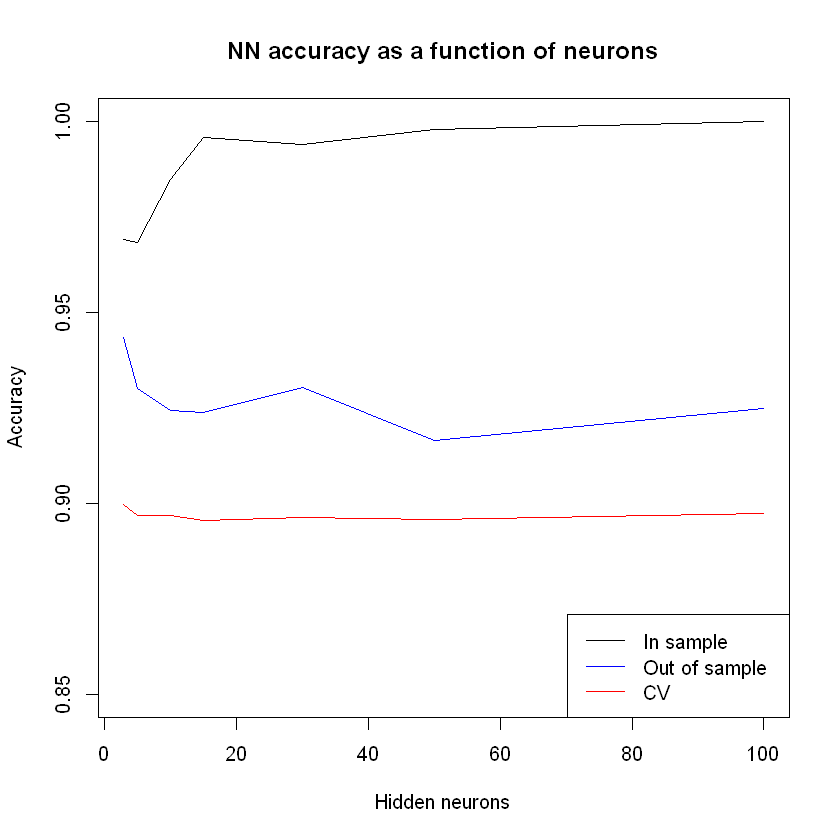

In [43]:
plot(hidden_nodes_vec,error_in_sample_vec,type="n",main="NN accuracy as a function of neurons",xlab="Hidden neurons",ylab="Accuracy",ylim=c(0.85,1))
lines(hidden_nodes_vec,error_in_sample_vec)
lines(hidden_nodes_vec,error_out_sample_vec,col="blue")
lines(hidden_nodes_vec,error_cv_vec,col="red")
legend("bottomright",legend=c("In sample","Out of sample","CV"),col=c("black","blue","red"),lty=c(1,1,1))

## Bagging Neural Networks

Given a standard training set $D$ of size $n$, bagging generates $m$ new training sets $D_i$, each of size $n′$, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations may be repeated in each $D_{i}$
Bagging leads to "improvements for unstable procedures" (Breiman, 1996), which include, for example, artificial neural networks, classification and regression trees. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors (Breiman, 1996).

We would like to study the impact of bagging on the problem at hand.
In order to do so you have to:

- Develop a basic (50/50 split) neural network model
- Develop a bagged version of the same model
- Compare (through tables and/or plots) the perfomances of the models

In [107]:
hidden_nodes <- 5

set.seed(1000)
model <- nnet(is_spam ~ ., data=train_data,size=hidden_nodes,skip=FALSE, maxit=3000,rang=0.2,MaxNWts=10000,trace=FALSE)
model

# 4.2 - In sample evaluation error computation
Y_pred<-predict(model,test_data[,-target_variable])
Y_hat <- Y_pred > threshold

accuracy <- displayResults(Y,Y_hat,"single model")

a 57-5-1 network with 296 weights
inputs: word_freq_make word_freq_address word_freq_all word_freq_3d word_freq_our word_freq_over word_freq_remove word_freq_internet word_freq_order word_freq_mail word_freq_receive word_freq_will word_freq_people word_freq_report word_freq_addresses word_freq_free word_freq_business word_freq_email word_freq_you word_freq_credit word_freq_your word_freq_font word_freq_000 word_freq_money word_freq_hp word_freq_hpl word_freq_george word_freq_650 word_freq_lab word_freq_labs word_freq_telnet word_freq_857 word_freq_data word_freq_415 word_freq_85 word_freq_technology word_freq_1999 word_freq_parts word_freq_pm word_freq_direct word_freq_cs word_freq_meeting word_freq_original word_freq_project word_freq_re word_freq_edu word_freq_table word_freq_conference char_freq_semicolon char_freq_left_paren char_freq_left_bracket char_freq_exclamation char_freq_dollar char_freq_pound capital_run_length_average capital_run_length_longest capital_run_length_total 
o

[1] "[INFO] - Confusion matrix single model :"
       
Y_hat   FALSE TRUE
  FALSE  1326   69
  TRUE     66  840
[1] "[INFO] - Misclassification rate single model : 0.0586701434159062"


In [102]:
bagging_samples <- 100

n_bag <- length(train_data)
Y_hat_models<-numeric()
Y_hat_bagged<-array(0,c(length(test_data),1))
Y <- test_data[,target_variable]
accuracy_vec<-array(0,c(1,bagging_samples))

for (i in 1:bagging_samples)
{
  set.seed(1717+i)
  # 1. Resample data from the training set
  I_bag <- sample(seq(1,n_bag),replace=TRUE)
  set.seed(555)
  # 2. Fit model
  model <- nnet (is_spam ~ .,train_data[I_bag,],skip=FALSE,
                   size=hidden_nodes, maxit=10000,trace=F,rang=0.2)
  Y_pred <- predict(model,test_data[,-target_variable])
  Y_hat_models <- cbind(Y_hat_models,Y_pred > threshold)
  accuracy_vec[i] <- displayResults(Y,Y_hat_models[,i],paste(i,"th model"))
}



[1] "[INFO] - Confusion matrix 1 th model :"
     
Y_hat FALSE TRUE
    0  1008  119
    1   384  790
[1] "[INFO] - Misclassification rate 1 th model : 0.218600608431117"
[1] "[INFO] - Confusion matrix 2 th model :"
     
Y_hat FALSE TRUE
    0  1243  218
    1   149  691
[1] "[INFO] - Misclassification rate 2 th model : 0.159495871360278"
[1] "[INFO] - Confusion matrix 3 th model :"
     
Y_hat FALSE TRUE
    0  1117  288
    1   275  621
[1] "[INFO] - Misclassification rate 3 th model : 0.244676227727075"
[1] "[INFO] - Confusion matrix 4 th model :"
     
Y_hat FALSE TRUE
    0  1040  182
    1   352  727
[1] "[INFO] - Misclassification rate 4 th model : 0.232073011734029"
[1] "[INFO] - Confusion matrix 5 th model :"
     
Y_hat FALSE TRUE
    0  1088  204
    1   304  705
[1] "[INFO] - Misclassification rate 5 th model : 0.22077357670578"
[1] "[INFO] - Confusion matrix 6 th model :"
     
Y_hat FALSE TRUE
    0   746  237
    1   646  672
[1] "[INFO] - Misclassification rate 6 th mo

In [103]:
# 3. Majority vote of the classifiers to make the prediction
# Computation trick : With classes being 0/1 if there is a majority of 1 classes, 
# the sum of all the values should be greater than the number of models/2
Y_hat_bagged <- as.numeric(apply(Y_hat_models,1,sum) > (bagging_samples/2))

accuracy_bag <- displayResults(Y,Y_hat_bagged,"bagged model")

print(paste("Average misclassification rate across the individual models:", 1-mean(accuracy_vec)))

[1] "[INFO] - Confusion matrix bagged model :"
     
Y_hat FALSE TRUE
    0  1237   79
    1   155  830
[1] "[INFO] - Misclassification rate bagged model : 0.101694915254237"
[1] "Average accuracy across the individual models: 0.231069100391134"


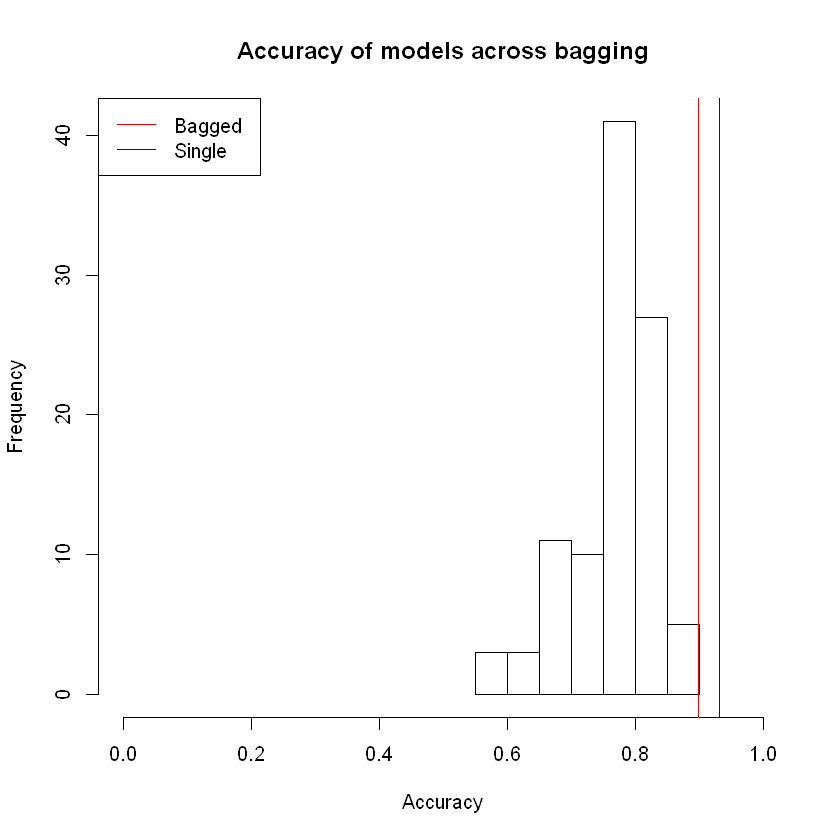

In [106]:
hist(accuracy_vec,main='Accuracy of models across bagging',xlab="Accuracy",xlim=c(0,1))
abline(v=accuracy_bag,col="red")
abline(v=accuracy,col="blue")
legend("topleft",legend=c("Bagged","Single"),col=c("red","blue"),lty=c(1,1))

## Bonus - Caret

In [4]:
library(caret)
fitControl <- trainControl(## 10-fold CV
                           method = "cv",
                           number = 3)

parameterGrid <-  expand.grid(decay=0,
                              size=c(3,5,10,15,20,50))

                        
parameterGrid



Warning message:
"package 'caret' was built under R version 3.4.4"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.2"Loading required package: ggplot2

Attaching package: 'caret'

The following objects are masked from 'package:RSNNS':

    confusionMatrix, train



decay,size
0,3
0,5
0,10
0,15
0,20
0,50


In [117]:
set.seed(825)
model_caret <- train(is_spam ~ ., data = train_data, 
                 method = "nnet", 
                 trControl = fitControl, 
                 verbose = FALSE,
                 skip=FALSE,
                 maxit=10000,
                 trace=F,
                 rang=0.2,
                 MaxNWts=10000,
                 ## Now specify the exact models 
                 ## to evaluate:
                 tuneGrid = parameterGrid)
model_caret

Neural Network 

2300 samples
  57 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 1534, 1533, 1533 
Resampling results across tuning parameters:

  size  Accuracy   Kappa    
   3    0.9182567  0.8298434
   5    0.9113077  0.8120088
  10    0.9156542  0.8231633
  15    0.9052211  0.8027368
  20    0.9078264  0.8068880
  50    0.9108692  0.8124990

Tuning parameter 'decay' was held constant at a value of 0
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were size = 3 and decay = 0.

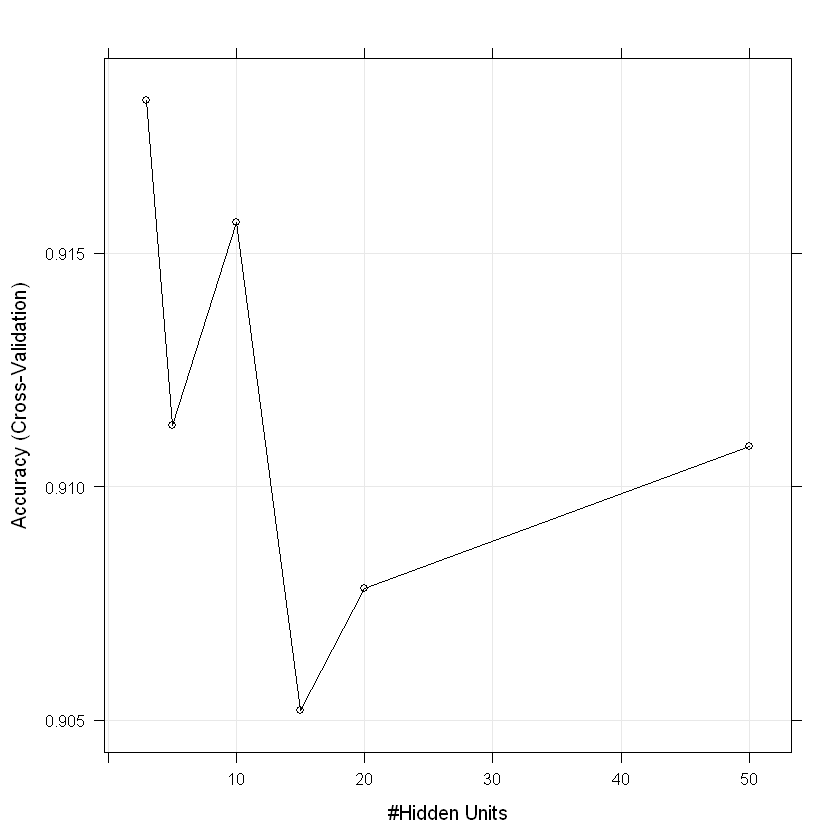

In [118]:
trellis.par.set(caretTheme())
plot(model_caret)

## Radial Basis Functions - RSNNS

The following code allows to fit a radial basis function (RBF [Slides 62-67](https://uv.ulb.ac.be/pluginfile.php/1257539/mod_resource/content/3/algos.pdf)) model, using the R package RSNNS, setting the number of centers to 5 and the maximum number of iterations to 10000. 


In [16]:
Y_train <- as.numeric(levels(train_data[,target_variable]))[train_data[,target_variable]]
Y_test <- as.numeric(levels(test_data[,target_variable]))[test_data[,target_variable]]

In [64]:
pca_train <- prcomp(train_data[, -target_variable],center=TRUE,scale.=TRUE,retx=TRUE)
pca_test <- prcomp(train_data[, -target_variable],center=TRUE,scale.=TRUE,retx=TRUE)

In [65]:
rbfn_model <- RSNNS::rbf(as.matrix(pca_train$x[,1:5]), 
                         as.matrix(Y_train), 
                         size=5,    # number of centers, ie, number of neurons in hidden layer
                         maxit=10000,
                         shufflePatterns=TRUE,
                         linout=FALSE) # max number of iterations to learn 

Y_pred_rbfn <- predict(rbfn_model,pca_test$x[,1:5])

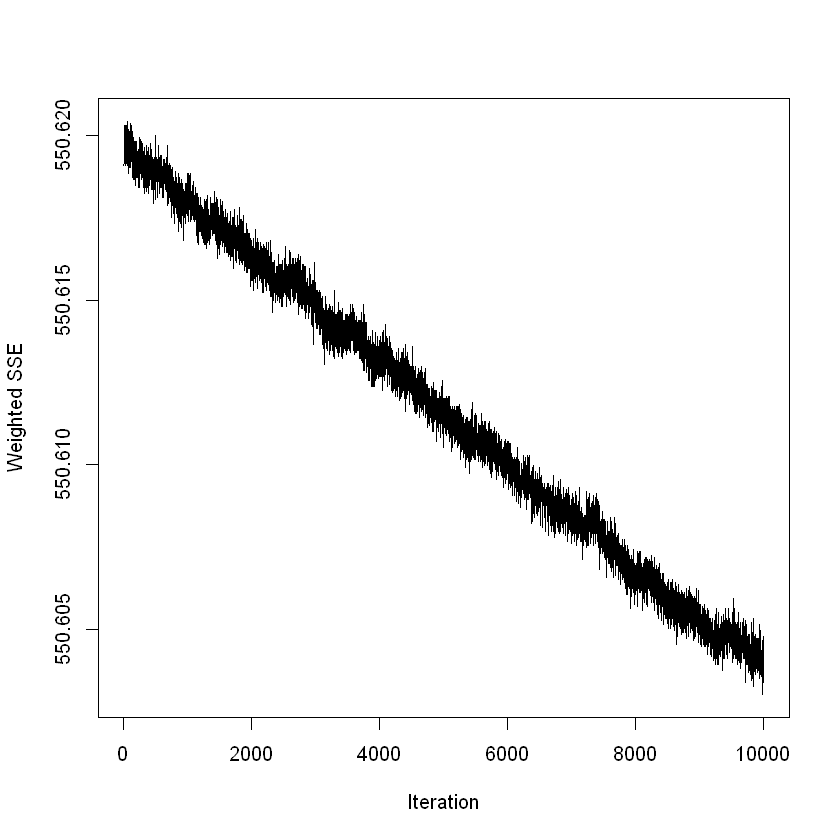

In [66]:
plotIterativeError(rbfn_model)

In [57]:
confusion_matrix <- table(round(Y_pred_rbfn),Y_test)
confusion_matrix

   Y_test
       0    1
  0 1407  894

In [44]:
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("[INFO] - Misclassification Rate - RSNNS:",misclassification_rate))


[1] "[INFO] - Misclassification Rate - RSNNS: 0.146458061712299"


In [71]:
centers <- c(5,10,15,20,30,50,100,150,200)
accuracy_vec <- numeric()

for(center in centers){
    rbfn_model <- RSNNS::rbf(as.matrix(train_data[,-target_variable]), 
                         as.matrix(Y_train), 
                         size=center,    # number of centers, ie, number of neurons in hidden layer
                         maxit=1000) # max number of iterations to learn 

    Y_pred_rbfn <- predict(rbfn_model, test_data[,-target_variable])
    confusion_matrix <- table(ifelse(round(Y_pred_rbfn) == 0,0,1),Y_test)
    print(confusion_matrix)
    accuracy <- (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
    misclassification_rate = 1 - accuracy
    print(paste("[INFO] - Misclassification Rate - RSNNS:",misclassification_rate))
    
    accuracy_vec <- cbind(accuracy_vec,accuracy)
}

   Y_test
       0    1
  0 1359  901
  1   16   25
[1] "[INFO] - Misclassification Rate - RSNNS: 0.398522381573229"
   Y_test
       0    1
  0 1373  917
  1    2    9
[1] "[INFO] - Misclassification Rate - RSNNS: 0.399391568883094"
   Y_test
       0    1
  0 1346  895
  1   29   31
[1] "[INFO] - Misclassification Rate - RSNNS: 0.401564537157758"
   Y_test
       0    1
  0 1358  898
  1   17   28
[1] "[INFO] - Misclassification Rate - RSNNS: 0.397653194263364"
   Y_test
       0    1
  0 1310  828
  1   65   98
[1] "[INFO] - Misclassification Rate - RSNNS: 0.388092133854846"
   Y_test
       0    1
  0 1355  890
  1   20   36
[1] "[INFO] - Misclassification Rate - RSNNS: 0.395480225988701"
   Y_test
      0   1
  0 922 243
  1 453 683
[1] "[INFO] - Misclassification Rate - RSNNS: 0.302477183833116"
   Y_test
      0   1
  0 972 256
  1 403 670
[1] "[INFO] - Misclassification Rate - RSNNS: 0.286397218600608"
   Y_test
      0   1
  0 929 251
  1 446 675
[1] "[INFO] - Misclassificatio